# BERT를 이용하여, Question_Answering 구현하기

BERT(Bi-directional Encoder Representations from Transformers)의 특징은 다음과 같이 생각할 수 있음

1. BERT는 bi-directional Transformer로 이루어진 언어모델
2. Multi head attention에서 encoder 부분의 12개 연결로 이루어짐
3. Pre-Trained BERT 언어모델 위에 fine-tuning layer를 부착하여 다양한 NLP task를 수행 할 수 있음

![1](img/1.png)

따라서 아래 코드는 미리 구글에서 공개한 Pre-trained Bert 모델 위에 새롭게 구성한 fine-tuning layer를 부착하여 Question_Answering task를 수행하고자 함.

구글에서 미리 공개한 Pre-trained 모델은 다음과 같음

https://github.com/google-research/bert 의 모델을 다운 받아 설치 후, 진행함


BERT-Base 모델의 특징 : Multilingual Cased(104 languages), 12-layer, 768-hidden, 12-heads, 110M parameters 

코드는 직관적인 이해를 위해 Keras를 기반으로 구성되었으며, https://github.com/kimwoonggon 의 내용을 참고하였으며

Data는 KorQuad v1.0을 기준으로 학습하였음.(https://korquad.github.io/dataset/KorQuAD_v1.0_train.json)

전체적인 구성은 [데이터 전처리 - 사전 학습 모델 불러오기 - 파인튜닝 layer 구성하기 - 모델 학습 - 예측 하기] 순서로 구성되어 있음

이제부터 시작합니다.

실행을 위한, bert의 사용을 쉽게 하기 위한 keras-bert, radam optimaizer 라이브러리 설치 및 import 과정

In [2]:
#!pip install keras-bert
#!pip install keras-radam

In [3]:
import tensorflow as tf

import pandas as pd
import numpy as np  
import re
import pickle

import keras as keras
from keras.models import load_model
from keras import backend as K
from keras import Input, Model
from keras import optimizers

from keras import backend as K
from keras.layers import Layer

import codecs
from tqdm import tqdm
import shutil
import json
import os

Using TensorFlow backend.


In [4]:
from keras_bert import load_trained_model_from_checkpoint, load_vocabulary
from keras_bert import Tokenizer
from keras_bert import AdamWarmup, calc_train_steps

from keras_radam import RAdam

KorQuAD_v1.0의 train.json의 원활한 이용을 위해, pandas의 dataframe 형식으로 읽어옴.

(실제 코드는 같은 폴더의 squad_json_to_dataframe.py를 참고)

In [5]:
import squad_json_to_dataframe
from squad_json_to_dataframe import squad_json_to_dataframe_train

train = squad_json_to_dataframe_train("KorQuAD_v1.0_train.json")

# 60407개의 question, context, text(answer)로 구성되어 있음

Reading the json file
processing...
shape of the dataframe is (60407, 6)
Done


In [6]:
train

,index,question,context,text,answer_start,c_id
0,6566495-0-0,바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?,1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로...,교향곡,54,0
1,6566495-0-1,바그너는 교향곡 작곡을 어디까지 쓴 뒤에 중단했는가?,1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로...,1악장,421,0
2,6566495-0-2,바그너가 파우스트 서곡을 쓸 때 어떤 곡의 영향을 받았는가?,1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로...,베토벤의 교향곡 9번,194,0
3,6566518-0-0,1839년 바그너가 교향곡의 소재로 쓰려고 했던 책은?,1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로...,파우스트,15,0
4,6566518-0-1,파우스트 서곡의 라단조 조성이 영향을 받은 베토벤의 곡은?,1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로...,합창교향곡,354,0
...,...,...,...,...,...,...
60402,6467478-1-1,뉴델리 메탈로 베타락마제가 처음 감염 된 지역은 어디인가?,"유전자의 이름은 인도의 수도 뉴델리의 이름을 따 붙여졌는데, 이는 2009년 용 (...",인도,73,9604
60403,6467478-2-0,균은 유전자를 균에게 전달 할 수있는데 이러한 현상을 나타낸 용어는 무엇인가?,"2010년 8월, 저널 The Lancet Infectious Diseases에 최...",유전자 전달,253,9605
60404,6467478-2-1,박테리아가 NDM-1 유전자를 가지고 있을때 발생하는 전파를 분석하기위해 사용된 영...,"2010년 8월, 저널 The Lancet Infectious Diseases에 최...",37건,129,9605
60405,6490801-2-0,NDM-1 유전자를 가진 박테리아가 감수성을 보인 폴리믹슨 계열 항생제는?,"2010년 8월, 저널 The Lancet Infectious Diseases에 최...",콜리스틴,404,9605


실제 사용하는 몇 가지 변수들을 다음과 같이 설정한다.

In [7]:
SEQ_LEN = 384    # question, context의 토큰화된 sequence length는 토큰 개수 기준 최대 384개를 이용함. 일정 길이 이상이 되면 코랩에서 실행이 어려움
BATCH_SIZE = 10  # Batch_size는 10
EPOCHS=3         # 실제로 학습은 3회 진행하였으나, 실제 학습 할때는 1회 학습 후 저장, 1회 학습 후 저장, ... 함.
LR=3e-5          # Learnning rate = 3e-5

DATA_COLUMN = "context"                   #train 데이터의 context column
QUESTION_COLUMN = "question"              #train 데이의 question column
TEXT = "text"                             #train 데이터의 text(answer) column

pretrained_path ="bert"                                               # 사전 학습 모델이 저장된 폴더
config_path = os.path.join(pretrained_path, 'bert_config.json')       # 사전 학습 모델의 여러 설정 사항
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')    # 사전 학습 모델
vocab_path = os.path.join(pretrained_path, 'vocab.txt')               # 사전 학습 모델 vocab

사전 학습 모델의 vocab을 이용하여 단어장 만들기

In [8]:
token_dict = {}
with codecs.open(vocab_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        if "_" in token:
            token = token.replace("_","")
            token = "##" + token
        token_dict[token] = len(token_dict)

reverse_token_dict = {v : k for k, v in token_dict.items()}

사전 학습 모델의 단어장을 기반으로한 tokenizer 함수

In [9]:
class inherit_Tokenizer(Tokenizer):
    def _tokenize(self, text):
        if not self._cased:
            text = text
            
            text = text.lower()
        spaced = ''
        for ch in text:
            if self._is_punctuation(ch) or self._is_cjk_character(ch):
                spaced += ' ' + ch + ' '
            elif self._is_space(ch):
                spaced += ' '
            elif ord(ch) == 0 or ord(ch) == 0xfffd or self._is_control(ch):
                continue
            else:
                spaced += ch
        tokens = []
        for word in spaced.strip().split():
            tokens += self._word_piece_tokenize(word)
        return tokens

In [10]:
tokenizer = inherit_Tokenizer(token_dict)

![2](img/2.png)

Bert 모형에 들어갈

인풋은 Question과 Paragraph(Context)의 token으로 구성되어 있고, 아웃풋은 Paragraph(Context)에서의 시작 토큰과 끝나는 토큰의 순서로 구성되어 있음

따라서 약 60,000개의 데이터의 인풋과 아웃풋을 이 과정으로 전처리 함.

![3](img/3.png)

특히, 인풋은 Token과 Segment(문장 구분, 여기서는 Question과 Paragraph를 각각 0,1로 구분함), Positional Embeddings 과정으로 이루어짐.

Postional Embeddings 과정은 사전 학습 모델에 포함되어 있으므로, 

우리는 각 인풋 데이터를 토큰화 + Segment(문장구분)을 전처리 과정에 포함시켜 진행함.

In [11]:
i = 0
question = train['question'][i]
context = train['context'][i]
text = train['text'][i]
print(question,"\n")
print(context,"\n")
print(text)

바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가? 

1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다. 

교향곡


In [12]:
print(tokenizer.tokenize(question, context),"\n")
print(tokenizer.tokenize(text))

['[CLS]', '바', '##그', '##너', '##는', '괴', '##테', '##의', '파', '##우스', '##트를', '읽', '##고', '무', '##엇', '##을', '쓰', '##고', '##자', '했', '##는', '##가', '?', '[SEP]', '1839', '##년', '바', '##그', '##너', '##는', '괴', '##테', '##의', '파', '##우스', '##트', '##을', '처음', '읽', '##고', '그', '내', '##용', '##에', '마', '##음', '##이', '끌', '##려', '이를', '소', '##재', '##로', '해', '##서', '하나의', '교', '##향', '##곡', '##을', '쓰', '##려', '##는', '뜻', '##을', '갖', '##는다', '.', '이', '시', '##기', '바', '##그', '##너', '##는', '1838', '##년에', '빛', '독', '##촉', '##으로', '산', '##전', '##수', '##전을', '다', '걲', '##은', '상', '##황', '##이', '##라', '좌', '##절', '##과', '실', '##망', '##에', '가', '##득', '##했으며', '메', '##피', '##스', '##토', '##펠', '##레스', '##를', '만', '##나는', '파', '##우스', '##트', '##의', '심', '##경', '##에', '공', '##감', '##했다', '##고', '한다', '.', '또한', '파', '##리에', '##서', '아', '##브', '##네', '##크', '##의', '지', '##휘', '##로', '파', '##리', '음악', '##원', '관', '##현', '##악', '##단', '##이', '연', '##주', '##하는', '베', '##토', '##벤', '##의', '교', '##향', '##곡', '9'

In [13]:
Aa, Bb= tokenizer.encode(question, context)
print(" token ids : ", Aa, "\n","segment : ", Bb)

 token ids :  [101, 9318, 78136, 70162, 11018, 8905, 119351, 10459, 9901, 89108, 101825, 9642, 11664, 9294, 119137, 10622, 9511, 11664, 13764, 9965, 11018, 11287, 136, 102, 16221, 10954, 9318, 78136, 70162, 11018, 8905, 119351, 10459, 9901, 89108, 15184, 10622, 62849, 9642, 11664, 8924, 8996, 24974, 10530, 9246, 32158, 10739, 8973, 26737, 35756, 9448, 36210, 11261, 9960, 12424, 90387, 8907, 79544, 55670, 10622, 9511, 26737, 11018, 9153, 10622, 8854, 40410, 119, 9638, 9485, 12310, 9318, 78136, 70162, 11018, 16347, 27056, 9387, 9088, 119267, 11467, 9407, 16617, 15891, 54918, 9056, 100, 10892, 9414, 65649, 10739, 17342, 9686, 58931, 11882, 9489, 89292, 10530, 8843, 118813, 51491, 9272, 97146, 12605, 26444, 119394, 100929, 11513, 9248, 49742, 9901, 89108, 15184, 10459, 9491, 31720, 10530, 8896, 105197, 12490, 11664, 16139, 119, 19789, 9901, 46766, 12424, 9519, 52015, 77884, 20308, 10459, 9706, 119455, 11261, 9901, 12692, 74293, 14279, 8900, 30842, 119110, 24989, 10739, 9568, 16323, 12178, 

데이터 전처리를 60,000 라인에 적용하는 함수, 전처리 is all you need!

In [14]:
def convert_data(data_df):
    
    global tokenizer
    indices, segments, target_start, target_end = [], [], [], []
    for i in tqdm(range(len(data_df))):
        
        ids, segment = tokenizer.encode(data_df[QUESTION_COLUMN][i], data_df[DATA_COLUMN][i], max_len=SEQ_LEN)
        

        text = tokenizer.encode(data_df[TEXT][i])[0]

        text_slide_len = len(text[1:-1])
        for i in range(1,len(ids)-text_slide_len-1):  
            exist_flag = 0
            if text[1:-1] == ids[i:i+text_slide_len]:
                ans_start = i
                ans_end = i + text_slide_len - 1
                exist_flag = 1
                break
        
        if exist_flag == 0:
            ans_start = SEQ_LEN
            ans_end = SEQ_LEN

        indices.append(ids)
        segments.append(segment)

        target_start.append(ans_start)
        target_end.append(ans_end)

    indices_x = np.array(indices)
    segments = np.array(segments)
    target_start = np.array(target_start)
    target_end = np.array(target_end)
    
    del_list = np.where(target_start!=SEQ_LEN)[0]

    indices_x = indices_x[del_list]
    segments = segments[del_list]
    target_start = target_start[del_list]
    target_end = target_end[del_list]

    train_y_0 = keras.utils.to_categorical(target_start, num_classes=SEQ_LEN, dtype='int64')
    train_y_1 = keras.utils.to_categorical(target_end, num_classes=SEQ_LEN, dtype='int64')
    train_y_cat = [train_y_0, train_y_1]
    
    return [indices_x, segments], train_y_cat

def load_data(pandas_dataframe):
    data_df = pandas_dataframe
    
    
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_df[QUESTION_COLUMN] = data_df[QUESTION_COLUMN].astype(str)


    data_x, data_y = convert_data(data_df)

    return data_x, data_y

In [15]:
train_x, train_y = load_data(train)
# train_x = [ Question+Paraghraph Token, Segment ]
# train_y = [ target_start, target_end ]

100%|███████████████████████████████████████████████████████████████████████████| 60407/60407 [01:36<00:00, 628.09it/s]


In [16]:
train_x[0]

array([[   101,   9318,  78136, ...,  12178,   9011,    102],
       [   101,   9318,  78136, ...,   9011, 118783,    102],
       [   101,   9318,  78136, ...,   9011, 118783,    102],
       ...,
       [   101,   9319, 119351, ...,      0,      0,      0],
       [   101,    182,  10162, ...,      0,      0,      0],
       [   101,  19145,  17289, ...,      0,      0,      0]])

In [17]:
train_y[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

미리 다운로드 받은, pre-trained 모델을 불러온다.

모델은 크게 transformers의 encoder 부분 12개로 구성되어 있으며, 인풋정보로 token과 segment를 받아 처리한다.

In [18]:
model = load_trained_model_from_checkpoint(config_path, checkpoint_path, training=False, trainable=True, seq_len=SEQ_LEN,)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 384)          0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 384)          0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 384, 768), ( 91812096    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 384, 768)     1536        Input-Segment[0][0]              
____________________________________________________________________________________________

사전 학습 모델위에 파인튜닝 된 모델을 얹을 준비를 한다.

Korquad의 Answer는 정답을 위한 모든 토큰을 나타내 주는 것이 아닌, paragraph에 있는 정답의 첫번째 토큰의 위치와 마지막 토큰의 위치를 대답해준다.

Keras의 장점인 모델 수정의 편리함을 적극 활용할 수 있다. 큰 방향은 다음과 같다.

1. 마지막 encoder-12의 layer에서 나온 벡터의 전달을 위해, Masking 값을 True로 변환하는 layer
2. Answer의 첫번째 Token을 예측하는 layer
3. Answer의 마지막 Token을 예측하는 layer

In [50]:
class NonMasking(Layer):   
    def __init__(self, **kwargs):   
        self.supports_masking = True  
        super(NonMasking, self).__init__(**kwargs)   
  
    def build(self, input_shape):   
        input_shape = input_shape   
  
    def compute_mask(self, input, input_mask=None):   
        return None   
  
    def call(self, x, mask=None):   
        return x   
  
    def get_output_shape_for(self, input_shape):   
        return input_shape
    
class MyLayer_Start(Layer):

    def __init__(self,seq_len, **kwargs):
        
        self.seq_len = seq_len
        self.supports_masking = True
        super(MyLayer_Start, self).__init__(**kwargs)

    def build(self, input_shape):
        
        self.W = self.add_weight(name='kernel', 
                                 shape=(input_shape[2],2),
                                 initializer='uniform',
                                 trainable=True)
        super(MyLayer_Start, self).build(input_shape)

    def call(self, x):
        
        x = K.reshape(x, shape=(-1,self.seq_len,K.shape(x)[2]))
        x = K.dot(x, self.W)
        
        x = K.permute_dimensions(x, (2,0,1))

        self.start_logits, self.end_logits = x[0], x[1]
        
        self.start_logits = K.softmax(self.start_logits, axis=-1)
        
        return self.start_logits

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.seq_len)


class MyLayer_End(Layer):
    
    def __init__(self,seq_len, **kwargs):
        
        self.seq_len = seq_len
        self.supports_masking = True
        super(MyLayer_End, self).__init__(**kwargs)
  
    def build(self, input_shape):
        
        self.W = self.add_weight(name='kernel', 
                                 shape=(input_shape[2], 2),
                                 initializer='uniform',
                                 trainable=True)
        super(MyLayer_End, self).build(input_shape)

  
    def call(self, x):

        
        x = K.reshape(x, shape=(-1,self.seq_len,K.shape(x)[2]))
        x = K.dot(x, self.W)
        x = K.permute_dimensions(x, (2,0,1))
        
        self.start_logits, self.end_logits = x[0], x[1]
        
        self.end_logits = K.softmax(self.end_logits, axis=-1)
        
        return self.end_logits

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.seq_len)

기존의 사전 학습 모델에 layer 3개를 추가한다.

In [51]:
from keras.layers import merge, dot, concatenate
from keras import metrics

def get_bert_finetuning_model(model):
    
    inputs = model.inputs[:2]
    dense = model.output
    x = NonMasking()(dense)
    outputs_start = MyLayer_Start(SEQ_LEN)(x)
    outputs_end = MyLayer_End(SEQ_LEN)(x)
    bert_model = keras.models.Model(inputs, [outputs_start, outputs_end])
    bert_model.compile(
        optimizer=RAdam(learning_rate=LR, decay=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
  
    return bert_model

In [52]:
bert_model = get_bert_finetuning_model(model)
bert_model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 384)          0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 384)          0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 384, 768), ( 91812096    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 384, 768)     1536        Input-Segment[0][0]              
___________________________________________________________________________________________

학습... colab에서 GPU로 돌리더라도 엄청나게 오래걸리며, 모델을 저장한 용량도(약 700MB) 매우 크다...

혹시나 개인 PC에서 실행시키지 않길 바란다. 우리는 미리 학습된 모델을 Load할 예정이다.

In [54]:
# 실행은 필수로 colab에서... GPU를 사용하면 epochs =1 당 4~5시간 정도 소요.
# 연달아서 실행하면 자주 error가 뜨는 모습이 나타나기도 함. 1 epoch 실행 후, save, load 를 반복하는 방식으로 진행
# bert_model.fit(train_x, train_y, batch_size=10, validation_split=0.05, shuffle=False, verbose=1)
# bert_model.save_weights("korquad_1.h5")
# bert_model.compile(optimizer=RAdam(learning_rate=0.00003, decay=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
# bert_model.fit(train_x, train_y, batch_size=10, shuffle=False, verbose=1)
# bert_model.save_weights("korquad_2.h5")
# bert_model.compile(optimizer=RAdam(learning_rate=0.00001, decay=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
# bert_model.save_weights("korquad_3.h5")

In [55]:
bert_model = get_bert_finetuning_model(model)
bert_model.load_weights("korquad_3.h5")

이제 모든 준비가 끝났다. 학습한 모델을 토대로 Question, Answering을 예측하는 함수를 만들자.

In [65]:
## question과 paragraph를 받아서, token, segment를 만든다.

def convert_pred_data(question, doc):
    global tokenizer
    indices, segments = [], []
    ids, segment = tokenizer.encode(question, doc, max_len=SEQ_LEN)
    indices.append(ids)
    segments.append(segment)
    indices_x = np.array(indices)
    segments = np.array(segments)
    return [indices_x, segments]

def load_pred_data(question, doc):
    data_x = convert_pred_data(question, doc)
    return data_x

In [98]:
def predict_letter(question, doc):
  
    test_input = load_pred_data(question, doc)             # question과 paragraph를 token,segment로 변수에 저장
    test_start, test_end = bert_model.predict(test_input)  # 학습 모델에 넣고 answer의 start와 end token 예측   
  
    indexes = tokenizer.encode(question, doc, max_len=SEQ_LEN)[0] 
    start = np.argmax(test_start, axis=1).item()      # 예측한 start_token의 위치 
    end = np.argmax(test_end, axis=1).item()          # 예측한 end_token의 위치
    start_tok = indexes[start]                        # 예측한 start_token
    end_tok = indexes[end]                            # 예측한 end_token
    print("질문 : ", question)
  
    print("-"*70)
    print("텍스트 : ", end = " ")
  
    def split_text(text, n):                                  # context 줄바꾸기
        for line in text.splitlines():
            while len(line) > n:
                x, line = line[:n], line[n:]
                yield x
            yield line

    for line in split_text(doc, 70):
        print(line)

    print("-"*70)
    print("예측한 정답(토큰) : ", end = " ")
    print("\n")
    sentences = []
  
    for i in range(start, end+1):
        token_based_word = reverse_token_dict[indexes[i]]
        sentences.append(token_based_word)
        print(token_based_word, end= " ")                   # 예측한 정답, start와 end 토큰 사이의 모든 토큰을 보여줌
  
    print("\n")
    print("예측한 정답 : ", end = "")
    for w in sentences:
        if w.startswith("##"):
            w = w.replace("##", "")
        else:
            w = " " + w                                 # 예측한 정답의 ##를 제외하고 보여준다.
      
        print(w, end="")
    print("")

In [243]:
doc = '고대 그리스 수학자는 플라톤이다.'
question = "수학자는 누구인가?"

predict_letter(question, doc)

질문 :  수학자는 누구인가?
----------------------------------------------------------------------
텍스트 :  고대 그리스 수학자는 플라톤이다.
----------------------------------------------------------------------
예측한 정답(토큰) :  

플 ##라 ##톤 

예측한 정답 :  플라톤


In [281]:
def token_score(question, doc, sign):
    
    import matplotlib
    from matplotlib import font_manager, rc
    import platform
    import seaborn as sns

    if platform.system() == 'Windows':
        # 윈도우인 경우
        font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
        rc('font', family=font_name)
    else:    
        # Mac 인 경우
        rc('font', family='AppleGothic')
        
    matplotlib.pyplot.title('Token_scores')
    
    # Use plot styling from seaborn.
    sns.set(style='darkgrid')

    # Increase the plot size and font size.
    # sns.set(font_scale=1.5)
    matplotlib.pyplot.rcParams["figure.figsize"] = (16,8)

    test_input = load_pred_data(question, doc)             # question과 paragraph를 token,segment로 변수에 저장
    test_start, test_end = bert_model.predict(test_input)  # 학습 모델에 넣고 answer의 start와 end token 예측   
    
    s_scores = test_start
    #print(s_scores[0])
    e_scores = test_end

    indexes = tokenizer.encode(question, doc, max_len=SEQ_LEN)[0] 
    #print(indexes)
    
    sentences = []
    for i in range(0, SEQ_LEN):
        token_based_word = reverse_token_dict[indexes[i]]
        sentences.append(token_based_word)
    
    # Create a barplot showing the start word score for all of the tokens.
    if sign == "start":
        ax = sns.barplot(x=sentences[1:], y=s_scores[0][1:], ci=None)    
    else:
        ax = sns.barplot(x=sentences[1:], y=e_scores[0][1:], ci=None)
    # Turn the xlabels vertical.
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

    # Turn on the vertical grid to help align words to scores.
    ax.grid(True)

    matplotlib.pyplot.show()
    

In [287]:
question = "바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?"

doc="1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다." 

predict_letter(question, doc)

질문 :  바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?
----------------------------------------------------------------------
텍스트 :  1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다.
----------------------------------------------------------------------
예측한 정답(토큰) :  

교 ##향 ##곡 

예측한 정답 :  교향곡


Start Token의 예측 : 


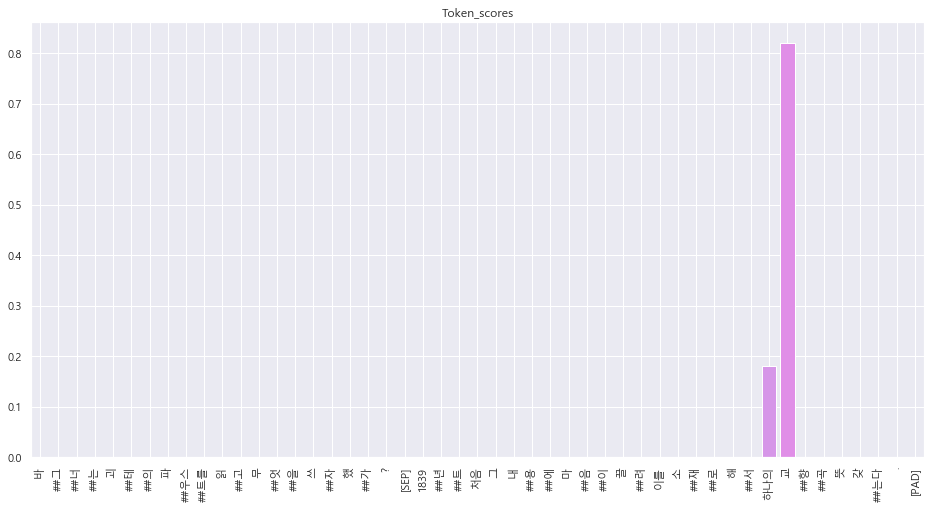

In [288]:
print("Start Token의 예측 : ")
token_score(question, doc, "start")

End Token의 예측 : 


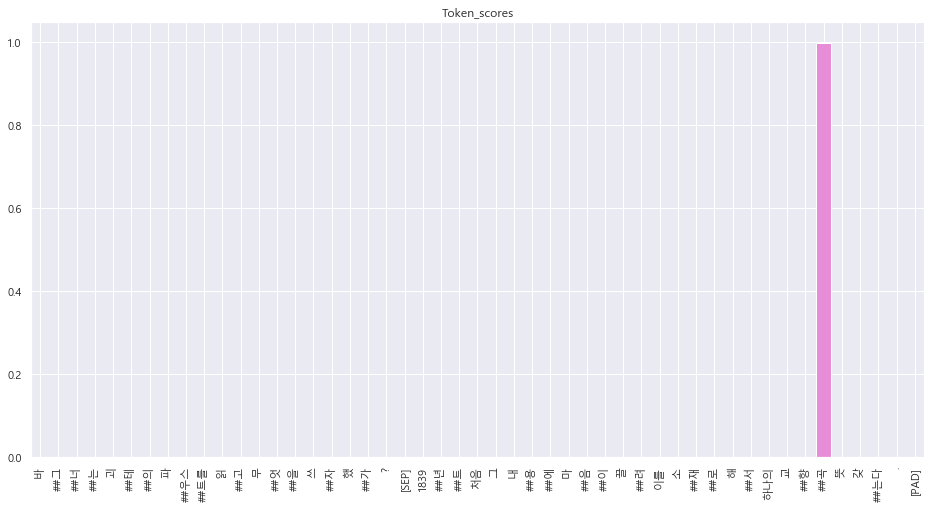

In [289]:
print("End Token의 예측 : ")
token_score(question, doc, "end")